In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model, model_from_json
import pickle
import glob

from geolomasexp.configuration import LSTMTrainingScriptConfig

from geolomasexp.data import read_time_series_from_csv
from geolomasexp.feature import (
    get_dataset_from_series,
    get_interest_variable
)
from geolomasexp.model_hyperopt import (
    get_lstm_nnet_opt
)
from geolomasexp.model import (train_val_test_split)


import ipdb


Using TensorFlow backend.
/home/munshkr/geolomas-exp/venv-geolomas-exp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/munshkr/geolomas-exp/venv-geolomas-exp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/munshkr/geolomas-exp/venv-geolomas-exp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2, 3, 4][2, 3][0.1, 0.8]5_hyperopt_history_2020-03-29_23:11:38.pickle


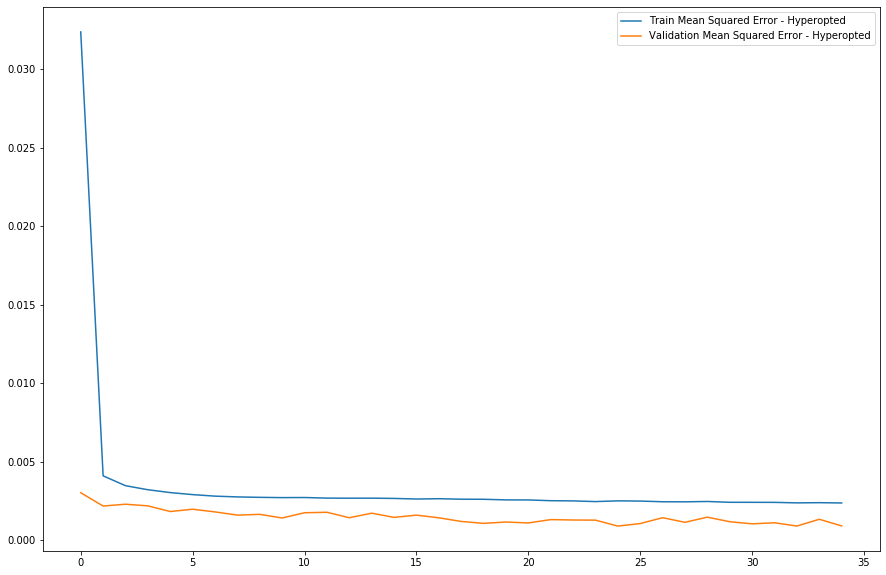

In [4]:
# plot history
read_prev = True

filename_hyperopt_history = glob.glob('../models/*_hyperopt_history_*.pickle')[-1]
filename_hyperopt_history = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2, 3, 4][2, 3][0.1, 0.8]5_hyperopt_history_2020-03-29_23:11:38.pickle'
#filename_history = '../models/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_history_2020-02-27_23:55:00.pickle'

print(filename_hyperopt_history)
#print(filename_history)

if read_prev:
    '''
    try:
        del history
    except:
        pass
    with open(filename_history, 'rb') as file_pi:
        history = pickle.load(file_pi)
    '''
    
    try:
        del history_hyper
    except:
        pass
    with open(filename_hyperopt_history, 'rb') as file_pi:
        history_hyper = pickle.load(file_pi)

plt.figure(figsize=(15,10))
#plt.plot(history.history['loss'], label='Train Mean Squared Error')
#plt.plot(history.history['val_loss'], label='Validation Mean Squared Error')
plt.plot(history_hyper.history['loss'], label='Train Mean Squared Error - Hyperopted')
plt.plot(history_hyper.history['val_loss'], label='Validation Mean Squared Error - Hyperopted')
plt.legend()
#plt.savefig('traininig_curve.png')
plt.show()

In [5]:

out_model_name = glob.glob('../models/*_hyperopt_model_*.hdf5')[-1]
out_model_name = '../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2, 3, 4][2, 3][0.1, 0.8]5_hyperopt_model_2020-03-29_23:11:38.hdf5'
print(out_model_name)
#out_model_name = '../models/esp:10_eps:2_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[1, 2, 3][2, 3][0.1, 0.8]3_hyperopt_model_2020-02-25_10:13:29.hdf5'
model_hyper = load_model(out_model_name)
print(model_hyper.summary())


../models/esp:10_eps:200_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temperature_basenet:4.4_midnet:4.2_hyperoptpars:[2, 3, 4][2, 3][0.1, 0.8]5_hyperopt_model_2020-03-29_23:11:38.hdf5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 15)             1020      
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 15)             1860      
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 15)             1860      
_______________________________________________________

In [61]:
layer_idx = 2
model_hyper.layers[layer_idx].input_shape

(None, 3, 9)

In [6]:

out_model_name_simple = '../models/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_model_2020-02-27_23:55:00.hdf5'
model_simple = load_model(out_model_name_simple)
print(model_simple.summary())
model_simple.layers[3].rate

OSError: Unable to open file (unable to open file: name = '../models/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_model_2020-02-27_23:55:00.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [9]:
# TODO: run this with the django venv be sure we are working on database data
from measures.models import Measure, Place, Station
def read_time_series_from_db(
            sensor='A601',
            date_col = 'date',
            hr_col = 'hr',
            min_col = 'minute',
            numeric_var = 'temperature',
            sensor_var = 'inme', # TODO : change this for station_code in all the script
            date_since = None
        ):
        # get the station (sensor)
        #station = Station.objects.get(code=sensor)
        # get all the measures from this station
        measures = Measure.objects.filter(station=Station.objects.get(code=sensor).id)
        if date_since is not None:
            measures = measures.filter(datetime__gte=date_since)

        self.log_success('Measures to read from database for sensor {} with query \n{}'.format(sensor,measures.query))
        # get a dataframe from the measures
        dataset = pd.DataFrame(list(measures.values('datetime','attributes')))
        self.log_success('Dataset from database of shape {}'.format(dataset.shape))
        # parse datetime column to get sepearae date, hr and minute columns
        dataset[date_col]=dataset.datetime.dt.date
        dataset[hr_col]=dataset.datetime.dt.hour
        dataset[min_col]=dataset.datetime.dt.minute
        # get the numeric var column parsing the json
        dataset[numeric_var] = dataset.attributes.apply(lambda x : x[numeric_var])
        dataset[sensor_var] = sensor

        # sort and re-index before returning
        dataset.sort_values([date_col,hr_col], inplace=True, ascending=True)
        dataset.reset_index(inplace=True)

ModuleNotFoundError: No module named 'measures'

In [10]:
# load dataset usando geolomas
config_file = '../config/config_train_lstm_temp_server.json'
script_config = LSTMTrainingScriptConfig(config_file)

n_past_steps = script_config.n_past_steps
input_csv = script_config.input_csv

date_col = script_config.date_col
hr_col = script_config.hr_col
target_var = script_config.numeric_var
# overwritting because in the database it is called temperature
target_var = 'temp'
sensor_var = script_config.sensor_var
sensor = script_config.target_sensor

# read the raw data
input_csv_nb = '../{}'.format(input_csv)
raw_dataset = read_time_series_from_csv(input_csv_nb,date_col,hr_col,target_var,sensor_var)
raw_dataset.head()

# get the time series dataset
time_series_dset = get_interest_variable(raw_dataset,sensor_var,date_col,hr_col,target_var,sensor)
time_series_dset.head()

# get the final dataset
sup_dataset,scaler = get_dataset_from_series(time_series_dset,n_past_steps)
print(scaler)
sup_dataset.head()

# split the dataset in train , test and validation
n_features = time_series_dset.shape[1]
dataset_splits = train_val_test_split(sup_dataset,n_past_steps,n_features,target_var)

train_X = dataset_splits['trainset']['X']
test_X = dataset_splits['testset']['X']

train_y = dataset_splits['trainset']['y']
test_y = dataset_splits['testset']['y']

read dataset of shape (160584, 3)
MinMaxScaler(copy=True, feature_range=(0, 1))
Sampleamos datasets de futuro a pasado
(96347, 5) 96347 (96347,)
(96347, 5, 1) (96347,) (32115, 5, 1) (32115,) (32117, 5, 1) (32117,)


In [13]:
# make a prediction
def make_prediction(model):
#    try:
#        del model
#    except:
#        pass

#    model = model_hyper
    print(model.summary())

    yhat = model.predict(test_X)
    tr_yhat = model.predict(train_X)

    # por que reshapeamos aca?
    test_X_2d = test_X.reshape((test_X.shape[0], n_past_steps*n_features))
    train_X_2d = train_X.reshape((train_X.shape[0], n_past_steps*n_features))
    # invert scaling for forecast
    # test
    # Por que lo que hace es armar una matrix n_samples,6 con una fila por cada datapoint con la primera columna con la prediccion y las otras las features?
    inv_yhat = concatenate((yhat, test_X_2d[:, -1*(n_features-1):]), axis=1)
    # afecta en algo aplicar invers_stransform sobre una sola columna que con tra la matriz?
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # train
    tr_inv_yhat = concatenate((tr_yhat, train_X_2d[:, -1*(n_features-1):]), axis=1)
    tr_inv_yhat = scaler.inverse_transform(tr_inv_yhat)
    tr_inv_yhat = tr_inv_yhat[:,0]

    # invert scaling for actual
    #test
    test_y_2d = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y_2d, test_X_2d[:, -1*(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    #train
    train_y_2d = train_y.reshape((len(train_y), 1))
    tr_inv_y = concatenate((train_y_2d, train_y_2d[:, -1*(n_features-1):]), axis=1)
    tr_inv_y = scaler.inverse_transform(tr_inv_y)
    tr_inv_y = tr_inv_y[:,0]


    # calculate MAE
    tr_mae = mean_absolute_error(tr_inv_y, tr_inv_yhat)
    print('Train MAE: %.3f' % tr_mae)
    mae = mean_absolute_error(inv_y, inv_yhat)
    print('Test MAE: %.3f' % mae)
    return inv_yhat,inv_y
    
    
predictions_hyper , inv_y = make_prediction(model_hyper)
#predictions_simple , inv_y = make_prediction(model_simple)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 15)             1020      
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 15)             1860      
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 15)             1860      
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5, 15)            

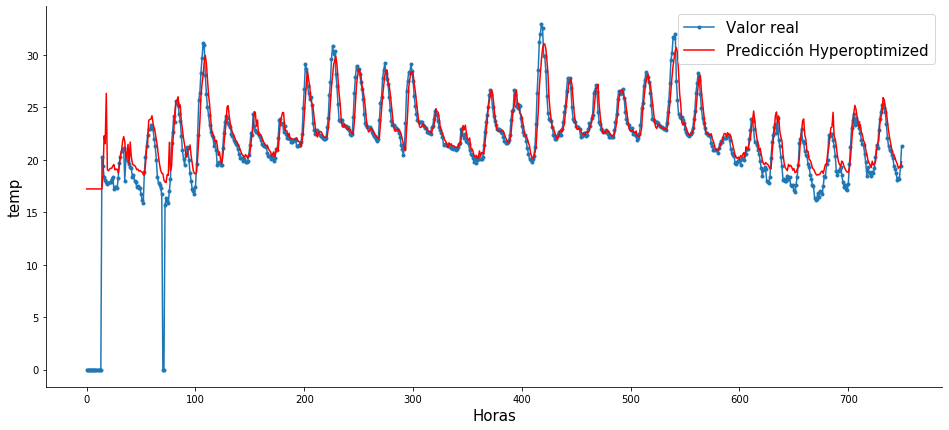

In [14]:
#%matplotlib inline

def plot_predictions(real,hyper,simple):
    inv_y = real
    inv_yhat = hyper
    inv_yhat_simple = simple
    # ploting the actual and prediction together
    total_time_steps = 750
    time_steps=[x for x in range(total_time_steps)]
    plt.figure(figsize=(15,7))

    #plt.plot(time_steps, Y_test[0][:total_time_steps], marker='.', label="actual")
    #plt.plot(time_steps, test_predict[:,0][:total_time_steps], 'r', label="prediction")

    plt.plot(time_steps, inv_y[:total_time_steps], marker='.', label="Valor real")
    plt.plot(time_steps, inv_yhat[:total_time_steps], 'r', label="Predicción Hyperoptimized")
    if inv_yhat_simple is not None:
        plt.plot(time_steps, inv_yhat_simple[:total_time_steps], 'g', label="Predicción Simple")

    # plt.tick_params(left=False, labelleft=True) #remove ticks
    #plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel(target_var, size=15)
    plt.xlabel('Horas', size=15)
    plt.legend(fontsize=15)
    plt.savefig('prediction_plot.png')
    plt.show()
    
plot_predictions(inv_y,predictions_hyper,None)

In [15]:
# TODO we don't have results
results = pd.read_csv('../results/A620_temp_results_2020-01-08_23:29:54.csv')


FileNotFoundError: [Errno 2] File ../results/A620_temp_results_2020-01-08_23:29:54.csv does not exist: '../results/A620_temp_results_2020-01-08_23:29:54.csv'